<a href="https://colab.research.google.com/github/cirilwakounig/MachineLearning/blob/main/6_Optimising_Models_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimising Models using XGBoost

This script is based on the XGBoost Tutorial provided by Kaggle in its 'Intermediate Machine Learning' Online Course. 

This script shows, how to optimise models with gradient boosting, using the extreme gradient boost (XGBoost) approach. Similar to Random Forests, XGBoost is an ensemble method, where predictions of several models are combined, to give the best overall result. 

Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble. 

The cycle of XGBoost is as follows: 

1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss. (Side note: The "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model.)
4. Finally, we add the new model to ensemble, and ...
5. ... repeat!

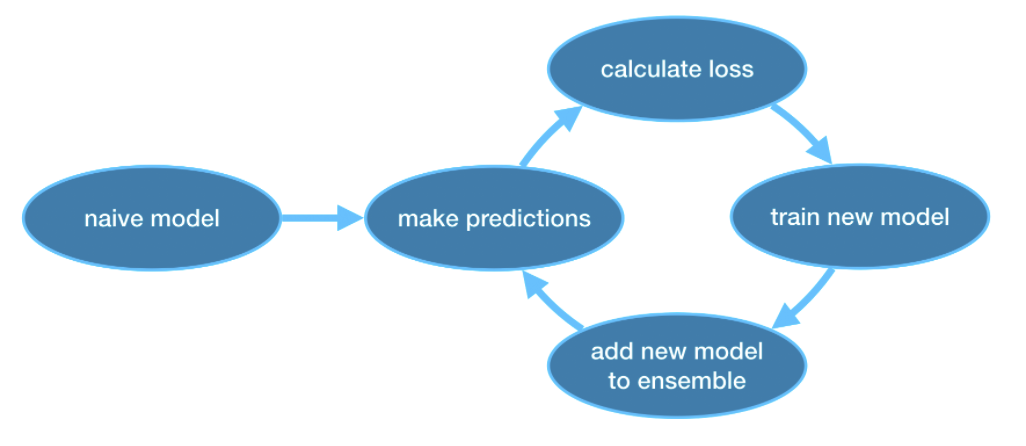




In [ ]:
# Import the required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Processing
from sklearn.model_selection import train_test_split

# XGBoost
from xgboost import XGBRegressor

# Validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

#### 1. Import and Process the required Data

---



##### 1.1 Import of Data

In [ ]:
# Import the Data Set Set
file_path_train = '/content/drive/MyDrive/Colab Notebooks/Kaggle Course/Intermediate Machine Learning/train.csv'
file_path_test = '/content/drive/MyDrive/Colab Notebooks/Kaggle Course/Intermediate Machine Learning/test.csv'

# Read the data
X = pd.read_csv(file_path_train, index_col = 'Id')
X_test = pd.read_csv(file_path_test, index_col = 'Id')

# Remove missing target values
X.dropna(axis = 0, subset = ['SalePrice'], inplace = True)   # Inplace = True overrides existing data frame
# Assign the dependent variable 
y = X.SalePrice

# Separate features from target
X.drop(['SalePrice'], axis = 1, inplace = True)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8,
                                                  test_size = 0.2, random_state = 0)

##### 1.2 Defining Categorical and Numerical Columns

Differentiate between categorical and numerical columns and select preferred data.

In [ ]:
# Cardinality refers to the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if 
                    X_train[cname].nunique() < 10 and 
                    X_train[cname].dtype == 'object']

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if 
                  X_train[cname].dtype in ['int64', 'float64']]

# Keep Selected Columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_val = X_val[my_cols].copy()
X_test = X_test[my_cols].copy()

# One-hot encode the data (to shorten the code, use pandas)
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_test = pd.get_dummies(X_test)

# Adjust columns of the dataframes, so that they match X_train
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)


#### 2. XGBoost Model Development

---

In this section, a XGBoost Model will be developed. 

##### 2.1 Model Definition

In [ ]:
# Define Model
model1 = XGBRegressor(random_state = 0) # objective = 'reg:squarederror'

# Fit the Model
model1.fit(X_train,y_train)

[10:11:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

##### 2.2 Generate Predictions

In [ ]:
# Predict
preds1 = model1.predict(X_val)

# Validate Predictions
error1 = mean_absolute_error(y_val, preds1)
print(error1)

16803.434690710616


#### 3. Parameter Tuning

---



The XGBoost-model has a number of parameters that allow for a dramatic increase of accuracy, when optimised. The most important ones are: 

**n_estimators:** \
Specifies how many time to go through the modeling cycle. It is equal to the number of models that we include in the ensemble. Typical values range from 100-1000, depending on the learning rate. 
* Too low a value causes *underfitting*, leading to inaccurate predictions on both the training and test data.
* Too high a value causes *overfitting*, leading to accurate predictions on training data, but inaccurate prediction on test data.

**early_stopping_rounds** \
Offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stops improving. It is smart to set a high value for `n_estimators` and use `early_stopping_rounds` to find the optimal value. 

Due to random chance when using `early_stopping_rounds`, sometimes a single round where validation scores don't improve occurs and thus, one needs to specify a number of how many rounds of straight deterioration to allow before stopping. A value of 5 is reasonable. 

It is important to remember when using `early_stopping_rounds`, that the `eval_set` needs to be specified, indicating which set is supposed to be used for testing. 

> Note that if you want to later fit the model using the whole data, set n_estimators to whatever value was selected when running with early stopping. To predict, one should train on the whole dataset. 

**learning_rate**

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in.

This means each tree we add to the ensemble helps us less. So, we can set a higher value for `n_estimators` without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.

> In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets learning_rate=0.1.

**n_jobs**

On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the fit command.



##### 3.1 Develop the Model

In [ ]:
# Develop a new model with tuned parameters 
# High number of estimators, that will be capped during the fitting step
model2 = XGBRegressor(random_state = 0, 
                      n_estimators = 1000,  
                      learning_rate = 0.05,
                      n_jobs = 4,
                      objective = 'reg:squarederror',
                      colsample_bytree = 0.8,
                      max_depth = 6)

# Fitting the model with 5 early_stopping_rounds
model2.fit(X_train, y_train,
           early_stopping_rounds = 5,
           eval_set = [(X_val, y_val)],
           verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

##### 3.2 Generate Predictions

In [ ]:
# Predict
preds2 = model2.predict(X_val)

# Validate Predictions
error2 = mean_absolute_error(y_val, preds2)
print(error2)

16455.52022688356


#### 3. Performing Cross-Validation


---

After having created the pipeline, it can be used for cross-validation. 

In [ ]:
# Multiply the result with -1, since sklearn calculates a negative MAE
scores = -1 * cross_val_score(my_pipe, X, y, 
                              cv = 5, scoring = 'neg_mean_absolute_error')

# Average over all scores to get the mean score over all folds
print('Average MAE score for CV:', scores.mean())

Average MAE score for CV: 18276.410356164386


#### 4. Writing a function that consolidates the pipeline and cross-validation.

---



##### 4.1 Function Definition

In [ ]:
# This function contains both the pipeline statement as well as the cross-validation
def get_score(n_estimators, X, y):
    
    ### Pipeline
    # Preprocessor
    preprocessor = SimpleImputer()
    
    # Model
    model = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)
    
    # Pipeline Statement
    my_pipe = Pipeline(steps = [('preprocessor', preprocessor), 
                                ('model', model)])
    
    ### Cross-Validation
    scores = -1 * cross_val_score(my_pipe, X, y,
                                 cv = 3, scoring = 'neg_mean_absolute_error')

    return (scores.mean())

##### 4.2. Function Application

In [ ]:
# Iterating over the number of estimators allows a comparison of model performance
results = []
no_estimators = np.linspace(50,400,8,endpoint = True, dtype = 'Int64')

# Loop over the number of estimators and run the cross-validation-pipeline
for i in no_estimators:
  results.append(get_score(i,X,y))

##### 4.3 Display of Results

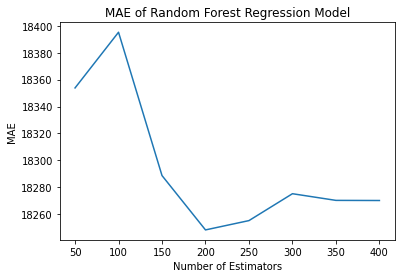

In [ ]:
# The results of the hyperparameter tuning are shown below
plt.plot(no_estimators, results)
plt.xlabel('Number of Estimators')
plt.ylabel('MAE')
plt.title('MAE of Random Forest Regression Model')
plt.show()

##### 4.4 Optimal Hyperparameter

In [ ]:
# The optimal n_estimator value can be computed as follows
opt_hyper = no_estimators[results.index(min(results))]

print('The optimal number of estimators is:', opt_hyper)

The optimal number of estimators is: 200
